In [2]:
from nibabel.freesurfer.io import read_geometry
import numpy as np
from pathlib import Path
import os
import pandas as pd
import re

In [3]:
def compute_surface_area(vertices, faces):
    """
    Compute total surface area of a triangulated mesh (vectorized).
    
    Parameters:
    -----------
    vertices : array (N, 3)
        Vertex coordinates
    faces : array (M, 3)
        Triangle faces (indices into vertices)
    
    Returns:
    --------
    total_area : float
        Total surface area in mm² (if vertices are in mm)
    """
    # Get all vertices for each face at once
    v0 = vertices[faces[:, 0]]  # (M, 3)
    v1 = vertices[faces[:, 1]]  # (M, 3)
    v2 = vertices[faces[:, 2]]  # (M, 3)
    
    # Compute edge vectors for all triangles
    edge1 = v1 - v0  # (M, 3)
    edge2 = v2 - v0  # (M, 3)
    
    # Cross product for all triangles
    cross_products = np.cross(edge1, edge2)  # (M, 3)
    
    # Area of each triangle
    triangle_areas = 0.5 * np.linalg.norm(cross_products, axis=1)  # (M,)
    
    # Total area
    total_area = np.sum(triangle_areas)
    
    return total_area


def sample_surface(vertices, faces, n_samples):
    """Sample points uniformly on a triangulated surface."""
    # Compute face areas (vectorized)
    v0 = vertices[faces[:, 0]]
    v1 = vertices[faces[:, 1]]
    v2 = vertices[faces[:, 2]]
    
    cross_products = np.cross(v1 - v0, v2 - v0)
    areas = 0.5 * np.linalg.norm(cross_products, axis=1)
    
    # Sample faces proportional to area
    face_probs = areas / areas.sum()
    sampled_faces = np.random.choice(len(faces), n_samples, p=face_probs)
    
    # Sample points within each face (barycentric coordinates)
    r1, r2 = np.random.random(n_samples), np.random.random(n_samples)
    sqrt_r1 = np.sqrt(r1)
    
    points = []
    normals = []
    for i, face_idx in enumerate(sampled_faces):
        face = faces[face_idx]
        v0, v1, v2 = vertices[face[0]], vertices[face[1]], vertices[face[2]]
        
        # Random point in triangle
        point = (1 - sqrt_r1[i]) * v0 + sqrt_r1[i] * (1 - r2[i]) * v1 + sqrt_r1[i] * r2[i] * v2
        points.append(point)
        
        # Face normal
        normal = np.cross(v1 - v0, v2 - v0)
        normal /= np.linalg.norm(normal)
        normals.append(normal)
    
    return np.array(points), np.array(normals)

def compute_surface_dose(source_vertices, source_faces, 
                         target_vertices, target_faces,
                         n_samples_source=1000, n_samples_target=1000):
    """
    Monte Carlo estimation of surface-to-surface dose.
    """
    # Sample points on both surfaces
    source_points, source_normals = sample_surface(
        source_vertices, source_faces, n_samples_source
    )
    
    target_points, target_normals = sample_surface(
        target_vertices, target_faces, n_samples_target
    )
    
    # Compute areas (needed for normalization)
    source_area = compute_surface_area(source_vertices, source_faces)
    target_area = compute_surface_area(target_vertices, target_faces)
    
    # Compute all pairwise distances
    from scipy.spatial.distance import cdist
    distances = cdist(target_points, source_points)
    
    # Integrate
    total_dose = 0
    for i, target_pt in enumerate(target_points):
        for j, source_pt in enumerate(source_points):
            r_vec = target_pt - source_pt
            d = distances[i, j]
            
            if d < 1e-6:  # Skip if too close
                continue
                
            r_hat = r_vec / d
            
            # Cosine factors
            cos_source = np.dot(source_normals[j], r_hat)
            cos_target = np.dot(target_normals[i], -r_hat)
            
            # Only count if both angles are favorable
            if cos_source > 0 and cos_target > 0:
                contribution = (cos_source * cos_target) / (d**2)
                total_dose += contribution
    
    # Normalize by number of samples (Monte Carlo integration)
    total_dose *= (source_area * target_area) / (n_samples_source * n_samples_target)
    
    return total_dose

In [4]:
def compute_surface_dose_exact(source_vertices, source_faces, source_normals,
                                target_vertices, target_faces, target_normals):
    """
    Compute surface-to-surface dose using actual mesh vertices.
    """
    # Compute vertex areas (1/3 of adjacent face areas)
    source_areas = compute_vertex_areas(source_vertices, source_faces)
    target_areas = compute_vertex_areas(target_vertices, target_faces)
    
    total_dose = 0
    
    # Double loop over vertices
    for i, target_vert in enumerate(target_vertices):
        for j, source_vert in enumerate(source_vertices):
            # Vector from source to target
            r_vec = target_vert - source_vert
            d = np.linalg.norm(r_vec)
            
            if d < 1e-6:  # Skip if same point
                continue
                
            r_hat = r_vec / d
            
            # Cosine factors
            cos_source = np.dot(source_normals[j], r_hat)
            cos_target = np.dot(target_normals[i], -r_hat)
            
            # Only count if both angles are favorable
            if cos_source > 0 and cos_target > 0:
                # Dose contribution weighted by areas
                contribution = (cos_source * cos_target * 
                              source_areas[j] * target_areas[i]) / (d**2)
                total_dose += contribution
    
    return total_dose

def compute_vertex_areas(vertices, faces):
    """Compute area associated with each vertex (1/3 of adjacent face areas)."""
    vertex_areas = np.zeros(len(vertices))
    
    for face in faces:
        v0, v1, v2 = vertices[face[0]], vertices[face[1]], vertices[face[2]]
        face_area = 0.5 * np.linalg.norm(np.cross(v1 - v0, v2 - v0))
        
        # Distribute area equally to three vertices
        vertex_areas[face[0]] += face_area / 3
        vertex_areas[face[1]] += face_area / 3
        vertex_areas[face[2]] += face_area / 3
    
    return vertex_areas

In [20]:
def compute_vertex_normals(vertices, faces):
    """Compute vertex normals (use any of the versions above)."""
    normals = np.zeros_like(vertices, dtype=np.float64)
    v0 = vertices[faces[:, 0]]
    v1 = vertices[faces[:, 1]]
    v2 = vertices[faces[:, 2]]
    face_normals = np.cross(v1 - v0, v2 - v0)
    np.add.at(normals, faces[:, 0], face_normals)
    np.add.at(normals, faces[:, 1], face_normals)
    np.add.at(normals, faces[:, 2], face_normals)
    norms = np.linalg.norm(normals, axis=1, keepdims=True)
    normals = normals / np.maximum(norms, 1e-10)
    return normals

def compute_vertex_areas(vertices, faces):
    """Compute area associated with each vertex."""
    vertex_areas = np.zeros(len(vertices))
    
    # Compute face areas
    v0 = vertices[faces[:, 0]]
    v1 = vertices[faces[:, 1]]
    v2 = vertices[faces[:, 2]]
    cross_products = np.cross(v1 - v0, v2 - v0)
    face_areas = 0.5 * np.linalg.norm(cross_products, axis=1)
    
    # Distribute to vertices (each vertex gets 1/3 of adjacent face areas)
    np.add.at(vertex_areas, faces[:, 0], face_areas / 3)
    np.add.at(vertex_areas, faces[:, 1], face_areas / 3)
    np.add.at(vertex_areas, faces[:, 2], face_areas / 3)
    
    return vertex_areas

def compute_surface_dose_exact(source_vertices, source_faces, source_normals,
                                target_vertices, target_faces, target_normals):
    """
    Compute surface-to-surface dose using actual mesh vertices.
    """
    # Compute vertex areas (needed for integration)
    source_areas = compute_vertex_areas(source_vertices, source_faces)
    target_areas = compute_vertex_areas(target_vertices, target_faces)
    
    print(f"Computing dose between {len(source_vertices)} source and {len(target_vertices)} target vertices...")
    print(f"Total iterations: {len(source_vertices) * len(target_vertices):,}")
    
    total_dose = 0
    
    # Double loop over vertices
    for i, target_vert in enumerate(target_vertices):
        if i % 100 == 0:  # Progress indicator
            print(f"  Progress: {i}/{len(target_vertices)} target vertices")
            
        for j, source_vert in enumerate(source_vertices):
            # Vector from source to target
            r_vec = target_vert - source_vert
            d = np.linalg.norm(r_vec)
            
            if d < 1e-6:  # Skip if same point
                continue
                
            r_hat = r_vec / d
            
            # Cosine factors
            cos_source = np.dot(source_normals[j], r_hat)
            cos_target = np.dot(target_normals[i], -r_hat)
            
            # Only count if both angles are favorable
            if cos_source > 0 and cos_target > 0:
                # Dose contribution weighted by areas
                contribution = (cos_source * cos_target * 
                              source_areas[j] * target_areas[i]) / (d**2)
                total_dose += contribution
    
    return total_dose

def compute_surface_dose_exact2(source_vertices, source_faces, source_normals,
                                target_vertices, target_faces, target_normals):
    """
    Compute surface-to-surface dose using actual mesh vertices.
    """
    # Compute vertex areas (needed for integration)
    source_areas = compute_vertex_areas(source_vertices, source_faces)
    target_areas = compute_vertex_areas(target_vertices, target_faces)
    
    print(f"Computing dose between {len(source_vertices)} source and {len(target_vertices)} target vertices...")
    print(f"Total iterations: {len(source_vertices) * len(target_vertices):,}")
    
    total_dose = 0
    
    # Double loop over vertices
    faces_in_view = set()

    for i, target_vert in enumerate(target_vertices):
        if i % 100 == 0:  # Progress indicator
            print(f"  Progress: {i}/{len(target_vertices)} target vertices")
            
        for j, source_vert in enumerate(source_vertices):
            # Vector from source to target
            r_vec = target_vert - source_vert
            d = np.linalg.norm(r_vec)
            
            if d < 1e-6:  # Skip if same point
                continue
                
            r_hat = r_vec / d
            
            # Cosine factors
            cos_source = np.dot(source_normals[j], r_hat)
            cos_target = np.dot(target_normals[i], -r_hat)
            
            # Only count if both angles are favorable
            if cos_source > 0 and cos_target > 0:
                # Dose contribution weighted by areas
                contribution = (cos_source * cos_target * 
                              source_areas[j] * target_areas[i]) / (d**2)
                total_dose += contribution
                faces_in_view.add(i)
            
    area_in_view = 0
    for i in faces_in_view:
        area_in_view += target_areas[i]
    
    return total_dose / area_in_view




In [6]:
thalamic_nuclei = [2, 4, 5, 6, 7, 8, 9, 10, 11, 12]
deep_grey = [13, 14, 26, 27, 28, 29, 30, 31, 32]


hips_thomas_ref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="index"
)["struct"]
hips_thomas_invref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="struct"
)["index"]

new_index = {ind: re.sub(r"(\w+)_(\d+)", r"\2-\1", ind) for ind in hips_thomas_ref}
new_index['MD_Pf_12'] = "12-MD-Pf"
new_ref = hips_thomas_invref.rename(index=new_index)

In [7]:
new_ref2 = pd.Series({new_ref[struct]: struct for struct in new_ref.index})
new_ref2

1     1-THALAMUS
2           2-AV
4           4-VA
5          5-VLa
6          6-VLP
7          7-VPL
8          8-Pul
9          9-LGN
10        10-MGN
11         11-CM
12      12-MD-Pf
13         13-Hb
14        14-MTT
26        26-Acc
27        27-Cau
28        28-Cla
29        29-GPe
30        30-GPi
31        31-Put
32         32-RN
33         33-GP
34        34-Amy
dtype: object

In [15]:
surf_dir = Path("/mnt/h/srs-9/fastsurfer/MNI152_T1_1mm1/MNI152_T1_1mm1/surf")

choroid_surf = surf_dir / "lh.choroid"
cp_vertices, cp_faces = read_geometry(choroid_surf)
cp_normals = compute_vertex_normals(cp_vertices, cp_faces)

lv_surf = surf_dir / "lh.aseg-lv"
lv_vertices, lv_faces = read_geometry(lv_surf)
lv_normals = compute_vertex_normals(lv_vertices, lv_faces)

ventricle_surf = surf_dir / "lh.ventricle_system"
ventricle_vertices, ventricle_faces = read_geometry(ventricle_surf)
ventricle_normals = compute_vertex_normals(ventricle_vertices, ventricle_faces)

midlineCSF_surf = surf_dir / "lh.midlineCSF"
midlineCSF_vertices, midlineCSF_faces = read_geometry(midlineCSF_surf)
midlineCSF_normals = compute_vertex_normals(midlineCSF_vertices, midlineCSF_faces)

vertices = {}
faces = {}
normals = {}
for struct in new_ref2[thalamic_nuclei+deep_grey]:
    surf = surf_dir / f"lh.{struct}"
    vertices[struct], faces[struct] = read_geometry(surf)
    normals[struct] = compute_vertex_normals(vertices[struct], faces[struct])
    
# pul_surf = surf_dir / "lh.8-Pul"
# pul_vertices, pul_faces = read_geometry(pul_surf)

# av_surf = surf_dir / "lh.2-AV"
# av_vertices, av_faces = read_geometry(av_surf)

# md_surf = surf_dir / "lh.12-MD-Pf"
# md_vertices, md_faces = read_geometry(md_surf)

In [20]:
vertices = cp_vertices
faces = cp_faces
normals = np.zeros_like(vertices, dtype=np.float64)
v0 = vertices[faces[:, 0]]
v1 = vertices[faces[:, 1]]
v2 = vertices[faces[:, 2]]
face_normals = np.cross(v0 - v1, v2 - v1)
face_normals[0]

array([ 0.02425472,  0.18642845, -0.02020693])

In [26]:
faces.max()

np.int64(1242)

In [27]:
surf_doses2 = {}
for key in vertices.keys():
    print(key)
    surf_doses2[key] = compute_surface_dose_exact2(ventricle_vertices, ventricle_faces, ventricle_normals, vertices[key], faces[key], normals[key])

2-AV
Computing dose between 9702 source and 227 target vertices...
Total iterations: 2,202,354
  Progress: 0/227 target vertices
  Progress: 100/227 target vertices
  Progress: 200/227 target vertices
4-VA
Computing dose between 9702 source and 533 target vertices...
Total iterations: 5,171,166
  Progress: 0/533 target vertices
  Progress: 100/533 target vertices
  Progress: 200/533 target vertices
  Progress: 300/533 target vertices
  Progress: 400/533 target vertices
  Progress: 500/533 target vertices
5-VLa
Computing dose between 9702 source and 200 target vertices...
Total iterations: 1,940,400
  Progress: 0/200 target vertices
  Progress: 100/200 target vertices
6-VLP
Computing dose between 9702 source and 998 target vertices...
Total iterations: 9,682,596
  Progress: 0/998 target vertices
  Progress: 100/998 target vertices
  Progress: 200/998 target vertices
  Progress: 300/998 target vertices
  Progress: 400/998 target vertices
  Progress: 500/998 target vertices
  Progress: 60

In [28]:
df_doses = pd.Series(surf_doses2, name="dose")
df_doses = df_doses.rename(index=new_ref)
df_doses.index.name = "index"
df_doses.to_csv("/home/srs-9/Projects/ms_mri/data/mni_viewfactor_ventricle_system_norm.csv")

In [24]:
df_doses

index
2     0.210793
4     0.125314
5     0.124654
6     0.189826
7     0.197154
8     0.309618
9     0.102629
10    0.137184
11    0.138570
12    0.161092
13    0.133907
14    0.053038
26    0.034467
27    0.078265
28    0.057833
29    0.067148
30    0.076435
31    0.066379
32    0.084049
Name: dose, dtype: float64

In [17]:
surf_doses = {}
for key in vertices.keys():
    surf_doses[key] = compute_surface_dose_exact(cp_vertices, cp_faces, cp_normals, vertices[key], faces[key], normals[key])

Computing dose between 1243 source and 227 target vertices...
Total iterations: 282,161
  Progress: 0/227 target vertices
  Progress: 100/227 target vertices
  Progress: 200/227 target vertices
Computing dose between 1243 source and 533 target vertices...
Total iterations: 662,519
  Progress: 0/533 target vertices
  Progress: 100/533 target vertices
  Progress: 200/533 target vertices
  Progress: 300/533 target vertices
  Progress: 400/533 target vertices
  Progress: 500/533 target vertices
Computing dose between 1243 source and 200 target vertices...
Total iterations: 248,600
  Progress: 0/200 target vertices
  Progress: 100/200 target vertices
Computing dose between 1243 source and 998 target vertices...
Total iterations: 1,240,514
  Progress: 0/998 target vertices
  Progress: 100/998 target vertices
  Progress: 200/998 target vertices
  Progress: 300/998 target vertices
  Progress: 400/998 target vertices
  Progress: 500/998 target vertices
  Progress: 600/998 target vertices
  Prog

In [28]:
surf_doses2 = {}
for key in vertices.keys():
    surf_doses2[key] = compute_surface_dose_exact(lv_vertices, lv_faces, lv_normals, vertices[key], faces[key], normals[key])

Computing dose between 7089 source and 227 target vertices...
Total iterations: 1,609,203
  Progress: 0/227 target vertices
  Progress: 100/227 target vertices
  Progress: 200/227 target vertices
Computing dose between 7089 source and 533 target vertices...
Total iterations: 3,778,437
  Progress: 0/533 target vertices
  Progress: 100/533 target vertices
  Progress: 200/533 target vertices
  Progress: 300/533 target vertices
  Progress: 400/533 target vertices
  Progress: 500/533 target vertices
Computing dose between 7089 source and 200 target vertices...
Total iterations: 1,417,800
  Progress: 0/200 target vertices
  Progress: 100/200 target vertices
Computing dose between 7089 source and 998 target vertices...
Total iterations: 7,074,822
  Progress: 0/998 target vertices
  Progress: 100/998 target vertices
  Progress: 200/998 target vertices
  Progress: 300/998 target vertices
  Progress: 400/998 target vertices
  Progress: 500/998 target vertices
  Progress: 600/998 target vertices


In [25]:
df_doses = pd.Series(surf_doses, name="dose")

In [28]:
new_ref

struct
1-THALAMUS     1
2-AV           2
4-VA           4
5-VLa          5
6-VLP          6
7-VPL          7
8-Pul          8
9-LGN          9
10-MGN        10
11-CM         11
12-MD-Pf      12
13-Hb         13
14-MTT        14
26-Acc        26
27-Cau        27
28-Cla        28
29-GPe        29
30-GPi        30
31-Put        31
32-RN         32
33-GP         33
34-Amy        34
Name: index, dtype: int64

In [ ]:
df_doses = pd.Series(surf_doses, name="dose")
df_doses = df_doses.rename(index=new_ref)
df_doses.index.name = "index"
df_doses.to_csv("/home/srs-9/Projects/ms_mri/data/mni_viewfactor_test1.csv")

In [11]:
print(compute_surface_area(cp_vertices, cp_faces))
print(compute_surface_area(pul_vertices, pul_faces))
print(compute_surface_area(av_vertices, av_faces))


654.1968707803137
805.450473748069
110.01189187523484


In [15]:
compute_surface_dose(cp_vertices, cp_faces, pul_vertices, pul_faces)

np.float64(212.21204649273653)

In [14]:
compute_surface_dose(cp_vertices, cp_faces, av_vertices, av_faces)

np.float64(19.53722465285752)

In [18]:
compute_surface_dose(cp_vertices, cp_faces, md_vertices, md_faces)

np.float64(50.71177789086865)

Normal vector lengths - min: 1.000000, max: 1.000000


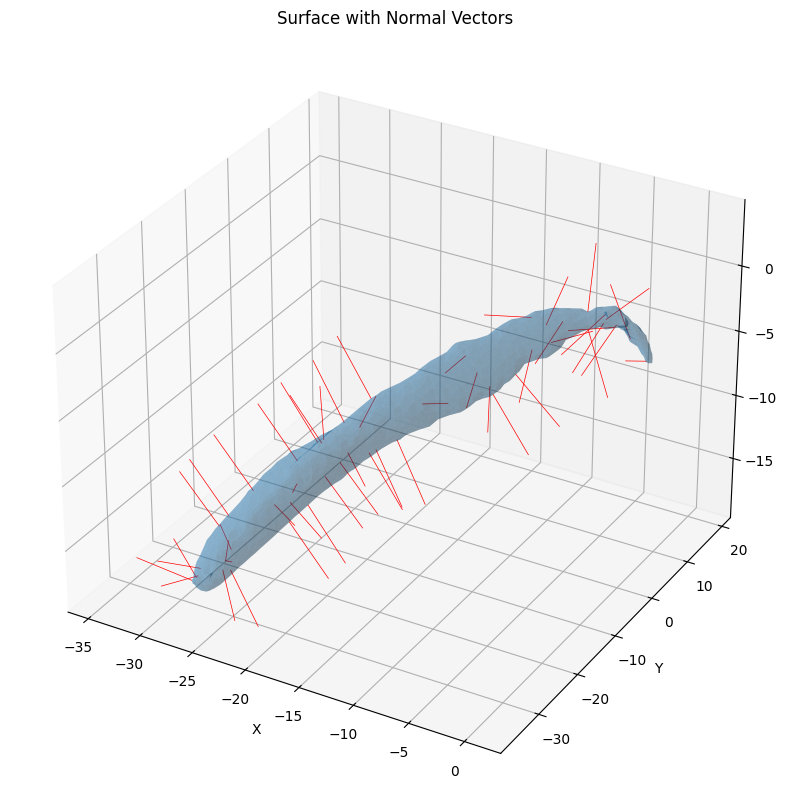

In [12]:
# Check that normals are unit vectors
norms = np.linalg.norm(cp_normals, axis=1)
print(f"Normal vector lengths - min: {norms.min():.6f}, max: {norms.max():.6f}")
# Should be very close to 1.0

# Visualize a few normals
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot surface
ax.plot_trisurf(
    cp_vertices[:, 0], 
    cp_vertices[:, 1], 
    cp_vertices[:, 2],
    triangles=cp_faces,
    alpha=0.3
)

# Plot some normal vectors
sample_indices = np.random.choice(len(cp_vertices), 50, replace=False)
for idx in sample_indices:
    start = cp_vertices[idx]
    end = start + 5 * cp_normals[idx]  # Scale by 5 for visibility
    ax.plot([start[0], end[0]], 
            [start[1], end[1]], 
            [start[2], end[2]], 'r-', linewidth=0.5)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Surface with Normal Vectors')
plt.show()